<IPython.core.display.Javascript object>


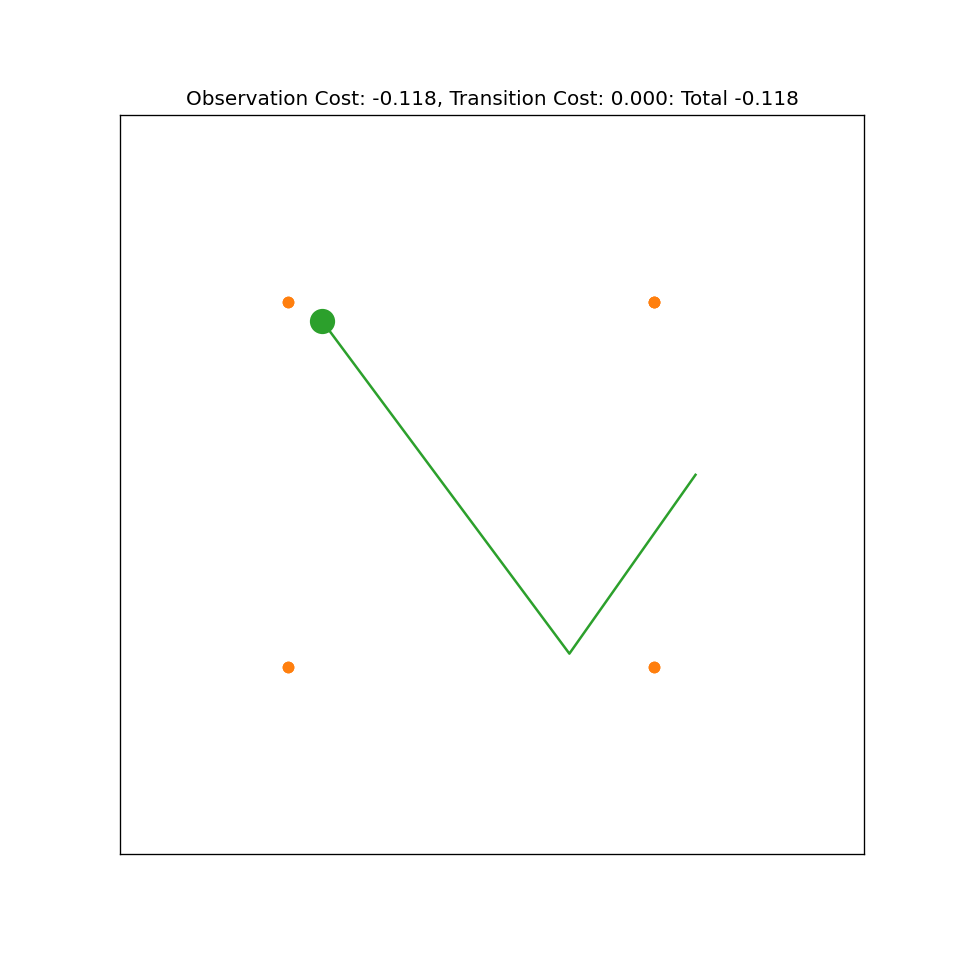

15

In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

sigma = 1

def get_csm(X, Y):
    X = np.array(X)
    Y = np.array(Y)
    XSqr = np.sum(X**2, axis=1)
    YSqr = np.sum(Y**2, axis=1)
    D = XSqr[:, None] + YSqr[None, :] - 2*X.dot(Y.T)
    D[D < 0] = 0
    return D

def get_score(X, Y):
    """
    Return accumulated observation cost and transition cost
    """
    dx = X - Y[0:X.shape[0], :]
    obs_cost = -np.sum(dx**2, axis=1)/(2*sigma**2)
    obs_cost = np.sum(obs_cost)
    
    dx = X[1::, :] - X[0:-1, :]
    tx_cost = -np.sum(dx**2, axis=1)/(2*sigma**2)
    tx_cost = np.sum(tx_cost)
    return obs_cost, tx_cost
    

# Create observation function
np.random.seed(0)
N = 2
t = np.linspace(0, 1, 200)
obs = 0.5*N*(1+np.array([np.cos(4*np.pi*t), np.sin(6*np.pi*t)])).T
obs += N*np.random.rand(obs.shape[0], 2)**20
obs /= np.max(obs, axis=0, keepdims=True)
obs *= N
obs = obs[100:200:20, :]

# Create grid
pix = np.arange(N)
x, y = np.meshgrid(pix, pix)
x = x.flatten()
y = y.flatten()
X = np.array([x, y]).T

# Initialize variable for my trajectory
XMy = []



fig = plt.figure(figsize=(8, 8))
## Have user choose their trajectory
plt.scatter(X[:, 0], X[:, 1], c='C1')
obs_loc = plt.scatter(obs[0, 0], obs[0, 1], c='C2', s=200)

def update(x, y):
    x = np.round(x)
    y = np.round(y)
    XMy.append([x, y])
    idx = len(XMy)
    XPlot = np.array(XMy)

    plt.scatter(x, y, c='C1')
    plt.plot(XPlot[-2::, 0], XPlot[-2::, 1], c='C0')
    if idx < Xg.shape[0]-1:
        obs_loc.set_offsets([obs[idx+1, 0], obs[idx+1, 1]])
    
    
    plt.plot(obs[0:idx+2, 0], obs[0:idx+2, 1], c='C2')
    
    obs_cost, tx_cost = get_score(XPlot, obs)
    
    plt.gca().set_title("Observation Cost: {:.3f}, Transition Cost: {:.3f}: Total {:.3f}".format(obs_cost, tx_cost, obs_cost+tx_cost))
    fig.canvas.draw()
    fig.canvas.flush_events()

def onclick(event):
    update(event.xdata, event.ydata)

# Compute greedy trajectory
D = get_csm(obs, X)
greedy = np.argmin(D, axis=1)
Xg = X[greedy, :]
    
update(X[greedy[0], 0], X[greedy[0], 1])

# Draw grid
plt.scatter(X[:, 1], X[:, 0], c='C1')
plt.axis("equal")
plt.gca().set_xticks([])
plt.gca().set_yticks([])

plt.show()

fig.canvas.mpl_connect('button_press_event', onclick)

In [37]:
def viterbi(X, obs):
    """
    Viterbi algorithm with possible locations X given observations obs
    """
    M = X.shape[0]
    T = obs.shape[0]
    DTrans = -get_csm(X, X)**2/(2*sigma**2)
    DObs = -get_csm(X, obs)/(2*sigma**2)
    
    S = np.zeros((M, T+1)) # Optimal accumulated costs
    B = np.zeros((M, T+1), dtype=int) # Optimal choices
    for t in range(1, T+1):
        for i in range(M):
            d = S[:, t-1] + DTrans[:, i]
            d = d + DObs[:, t-1]
            idx = np.argmax(d)
            B[i, t] = idx
            S[i, t] = d[idx]
    
    ## Backtracing
    i = np.argmax(S[:, -1])
    path = []
    for j in range(T, 0, -1):
        path.append(i)
        i = B[i, j]
    path.append(i)
    print(S)
    print(DTrans)
    print(DObs)
    path.reverse()
    return S, DTrans, DObs, path


# Compute optimal trajectory
S, DTrans, DObs, path = viterbi(X, obs)
print("max", np.argmax(S[:, -1]))
print(path)
html = "<table><tr><td></td>"
for t in range(S.shape[1]):
    html += "<td>t={}</td>".format(t)
html += "</tr>"
for k in range(S.shape[0]):
    html += "<tr><td>{}</td>".format(chr(ord('a')+k))
    for t in range(S.shape[1]):
        html += "<td>{:.2f}</td>".format(S[k, t])
    html += "</tr>"
html += "</table>"

html += "<table><tr><td></td>"
for t in range(DObs.shape[1]):
    html += "<td>t={}</td>".format(t)
html += "</tr>"
for k in range(DObs.shape[0]):
    html += "<tr><td>{}</td>".format(chr(ord('a')+k))
    for t in range(DObs.shape[1]):
        html += "<td>{:.2f}</td>".format(DObs[k, t])
    html += "</tr>"
html += "</table>"


html += "<table><tr><td></td>"
for t in range(DTrans.shape[1]):
    html += "<td>{}</td>".format(chr(ord('a')+t))
html += "</tr>"
for s in range(DTrans.shape[0]):
    html += "<tr><td>{}</td>".format(chr(ord('a')+s))
    for t in range(DTrans.shape[1]):
        html += "<td>{:.2f}</td>".format(DTrans[s, t])
    html += "</tr>"
html += "</table>"

fout = open("out.html", "w")
fout.write(html)
fout.close()

[[ 0.         -0.64563586 -0.67295229 -1.1268821  -1.48970103 -1.79122301]
 [ 0.         -0.14563586 -0.17295229 -1.03444617 -1.77366594 -1.81555029]
 [ 0.         -0.61828084 -1.10799412 -1.11360161 -1.13359131 -1.77388477]
 [ 0.         -0.11828084 -0.60799412 -1.02116569 -1.41755623 -1.79821206]]
[[ 0.  -0.5 -0.5 -2. ]
 [-0.5  0.  -2.  -0.5]
 [-0.5 -2.   0.  -0.5]
 [-2.  -0.5 -0.5  0. ]]
[[-0.76038948 -0.29662427 -0.4539298  -0.36281893 -0.30152198]
 [-0.14563586 -0.02731644 -0.86149388 -0.73921977 -0.04188435]
 [-0.73303446 -0.75902111 -0.00560749 -0.0199897  -0.64029346]
 [-0.11828084 -0.48971328 -0.41317157 -0.39639054 -0.38065583]]
max 2
[3, 3, 2, 2, 2, 2]


In [38]:
for p in path:
    print(chr(ord('a')+p), end=' ')

d d c c c c 